%%latex
\tableofcontents

# First notebook

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import pandas as pd
import torch
from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor

## Introduction

The conserved variables are $(D, S_i, \tau)$ and they are related to primitive variables, $w = (\rho, v^i, \epsilon, p)$, defined in the local rest frame of the fluid through (in units of light speed $c = 1$). The P2C is explicitly given:
\begin{equation}
D = \rho W \, , \quad S_i = \rho h W^2 v_i \, , \quad \tau = \rho h W^2 - p - D \, ,
\end{equation}
where we used
\begin{equation}
W = (1 - v^2)^{-1/2} \, , \quad h = 1 + \epsilon + \frac{p}{\rho} \, .
\end{equation}

Our first goal is to reproduce the results from [this paper](https://www.mdpi.com/2073-8994/13/11/2157). We first focus on what they call __NNEOS__ networks. These are networks which are trained to infer information on the equation of state (EOS). In its simplest form, the EOS is the thermodynamical relation connecting the pressure to the fluid's rest-mass density and internal energy $p = \bar{p}(\rho, \epsilon)$. We consider an __analytical $\Gamma$-law EOS__ as a benchmark:
\begin{equation}
    \bar{p}(\rho, \varepsilon) = (\Gamma - 1)\rho\epsilon \, ,
\end{equation}
and we fix $\Gamma = 5/3$ in order to fully mimic the situation of the paper.

## Step 1: Generating training data

We generate training data for the NNEOS networks as follows. We create a training set by randomly sampling the EOS on a uniform distribution over $\rho \in (0, 10.1)$ and $\epsilon \in (0, 2.02)$. We then compute three quantities:
\begin{itemize}
\item $p$, using the EOS defined above
\item $\chi := \partial p/\partial\rho$, inferred from the EOS
\item $\kappa := \partial p/\partial \epsilon$, inferred from the EOS
\end{itemize}

In [2]:
# Define the three functions determining the output
def eos(rho, eps, Gamma = 5/3):
    """Computes the analytical gamma law EOS from rho and epsilon"""
    return (Gamma - 1) * rho * eps

def chi(rho, eps, Gamma = 5/3):
    """Computes dp/drho from EOS"""
    return (Gamma - 1) * eps

def kappa(rho, eps, Gamma = 5/3):
    """Computes dp/deps from EOS"""
    return (Gamma - 1) * rho

In [5]:
# Define ranges of parameters to be sampled (see paper Section 2.1)
rho_min = 0
rho_max = 10.1
eps_min = 0
eps_max = 2.02

Note: the code is in comment, as the data has been generated already and we want to use the same dataset for reproducibility.

In [21]:
# number_of_datapoints = 10000 # 80 000 for train, 10 000 for test
# data = []

# for i in range(number_of_datapoints):
#     rho = random.uniform(rho_min, rho_max)
#     eps = random.uniform(eps_min, eps_max)
    
#     new_row = [rho, eps, eos(rho, eps), chi(rho, eps), kappa(rho, eps)]
    
#     data.append(new_row)

In [22]:
# header = ['rho', 'eps', 'p', 'chi', 'kappa']

# with open('NNEOS_data_test.csv', 'w', newline = '') as file:
#     writer = csv.writer(file)
#     # write header
#     writer.writerow(header)
#     # write data
#     writer.writerows(data)

In [24]:
data_train = pd.read_csv("NNEOS_data_train.csv")
data_train

,rho,eps,p,chi,kappa
0,9.770794,0.809768,5.274717,0.539845,6.513863
1,10.093352,0.575342,3.871421,0.383561,6.728901
2,1.685186,1.647820,1.851255,1.098547,1.123457
3,1.167718,0.408377,0.317913,0.272251,0.778479
4,7.750848,1.069954,5.528700,0.713303,5.167232
...,...,...,...,...,...
79995,3.985951,1.642317,4.364131,1.094878,2.657301
79996,6.948815,0.809021,3.747824,0.539347,4.632543
79997,8.423227,1.125142,6.318217,0.750095,5.615485
79998,4.748173,0.774870,2.452810,0.516580,3.165449


In case we want to visualize the datapoints (not recommended).

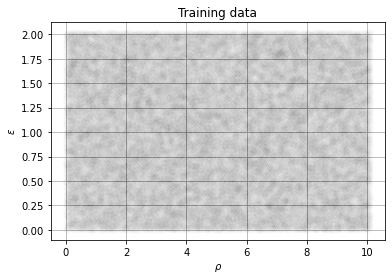

In [34]:
# rho = data_train['rho']
# eps = data_train['eps']

# plt.figure(figsize = (12,10))
# plt.plot(rho, eps, 'o', color = 'black', alpha = 0.005)
# plt.grid()
# plt.xlabel(r'$\rho$')
# plt.ylabel(r'$\epsilon$')
# plt.title('Training data')
# plt.show()

## Building the neural networks